In [ ]:
#Step 11 trains on the data from the hospital BIDMC and tests on the patients in MGB using random forest. 
#This data is coming from the testing data only. 

In [19]:
#Import all of the necessary modules. 
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import csv
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import (
    precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, 
    roc_auc_score, average_precision_score, accuracy_score, recall_score
)


In [2]:
#Load the CSV file into a DataFrame. 
df = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/Complete_merged_feature_matrix_notes_CPT_and_ICD_.csv')

#Remove rows where 'BDSPPatientID' is 122501769, due to the patient being over 120 years old. 
df = df[df['BDSPPatientID'] != 122501769]

#Save the DataFrame back to a CSV file. 
df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/Complete_merged_feature_matrix_notes_CPT_and_ICD_.csv', index=False)

In [3]:
#Load in the csv file. 
X = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/Complete_merged_feature_matrix_notes_CPT_and_ICD_.csv')

#Load y_data_pre from CSV and select relevant columns.
y_data = X[['BDSPPatientID', 'annot', 'hospital']]
y = y_data['annot']

#Merge X and y based on 'BDSPPatientID'
Xy = pd.read_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/Complete_merged_feature_matrix_notes_CPT_and_ICD_.csv')


In [5]:
#Conduct training on BIDMC and test on MGB using random forest. 

X = Xy.iloc[:,:-1]
y = Xy.iloc[:,-2]
X = X.loc[:, "CT":"ICD_852.2or3"]

#Separate the data by hospital. 
train_hospital = 'BIDMC'
test_hospital = 'MGB'

X_train = X[Xy['hospital'] == train_hospital]
y_train = y[Xy['hospital'] == train_hospital]

X_test = X[Xy['hospital'] == test_hospital]
y_test = y[Xy['hospital'] == test_hospital]

X_train = X_train.loc[:, "CT":"ICD_852.2or3"]
X_test = X_test.loc[:, "CT":"ICD_852.2or3"]

#Initialize variables for storing results. 
all_predictions = []
all_true_labels = []
all_row_numbers = []
auc_cv = []
auc_pr = []
f1_cv = []
cf_cv = []
predictions = []
roc_curves = []
pr_curves = []
feature_importances_dict = {feature: [] for feature in X.columns}

#Define and fit the model. 
model = RandomForestClassifier(
    n_estimators=100,
    random_state=2023,
    n_jobs=-1
)
search_spaces = {
    'n_estimators': (10, 200),
    'max_depth': (2, 10),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
}
model_cv = BayesSearchCV(
    model,
    search_spaces,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=47,
    cv=10,
    random_state=2023
)
model_cv.fit(X_train, y_train)
model = model_cv.best_estimator_

#Predict and evaluate. 
ytr_pred = model.predict_proba(X_train)[:, 1]
yte_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, cutoffs = roc_curve(y_train, ytr_pred)
best_cutoff = cutoffs[np.argmax(tpr - fpr)]
yte_pred_bin = (yte_pred > best_cutoff).astype(int)
auc_cv.append(roc_auc_score(y_test, yte_pred))
f1_cv.append(f1_score(y_test, yte_pred_bin))
cf_cv.append(confusion_matrix(y_test, yte_pred_bin))
predictions.append(yte_pred_bin)

#Save the model. 
model_filename = 'model_train_BIDMC_MGB_test_RF__best_model.pickle'
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model, 'cutoff': best_cutoff}, f)

#Compute the ROC and PR curves. 
fpr, tpr, cutoffs = roc_curve(y_test, yte_pred)
all_predictions.extend(yte_pred_bin)
all_true_labels.extend(y_test)
all_row_numbers.extend(Xy[Xy['hospital'] == test_hospital]['BDSPPatientID'])
roc_curves.append((fpr, tpr, roc_auc_score(y_test, yte_pred)))
precision, recall, thresholds = precision_recall_curve(y_test, yte_pred)
pr_curves.append((recall, precision, auc(recall, precision)))
auc_pr_loop = auc(recall, precision)
auc_pr.append(auc_pr_loop)
feature_importances = model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    feature_importances_dict[feature].append(importance)

#Print the feature importances. 
print("Feature importances for this fold:")
print(pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False))

print(auc_cv)
print(auc_pr)

#Save predictions to a CSV. 
df_pred = pd.DataFrame(data={
    'BDSPPatientID': Xy[Xy['hospital'] == test_hospital]['BDSPPatientID'].values,
    'y': y_test.values,
    'y_pred': yte_pred_bin,
    'y_pred_proba': yte_pred
})
df_pred.to_csv('MGB_y_and_y_pred.csv', index=False)


/home/gregory178/Desktop/NAX project/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Feature importances for this fold:
             Feature  Importance
24           sdh_pos    0.279495
21  neurosurgeri_pos    0.082389
25        subdur_pos    0.075185
68         ICD_S06.5    0.057147
18  midlin shift_pos    0.056340
..               ...         ...
65     known sdh_neg    0.000000
37     burr hole_neg    0.000000
34      acut sdh_neg    0.000000
46   chronic sdh_neg    0.000000
35  brain injuri_neg    0.000000

[71 rows x 2 columns]
[0.964584355163596]
[0.8402227515177098]


In [6]:
#Verify that the correct features are present. 
X_train = X_train.loc[:, "CT":"ICD_852.2or3"]
X_train.head()

,CT,MRI,acut sdh_pos,brain injuri_pos,brain mri_pos,burr hole_pos,stabl sdh_pos,craniectomi_pos,craniotomi_pos,ct head_pos,...,trauma_neg,prior sdh_neg,recent sdh_neg,resolv sdh_neg,known sdh_neg,history_sdh,ICD_I62.0,ICD_S06.5,ICD_432.1,ICD_852.2or3
1499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1500,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
1501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1502,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,1
1503,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
#Print the AUROC and AUPRC values. 
print(auc_cv)
print(auc_pr)

[0.964584355163596]
[0.8402227515177098]


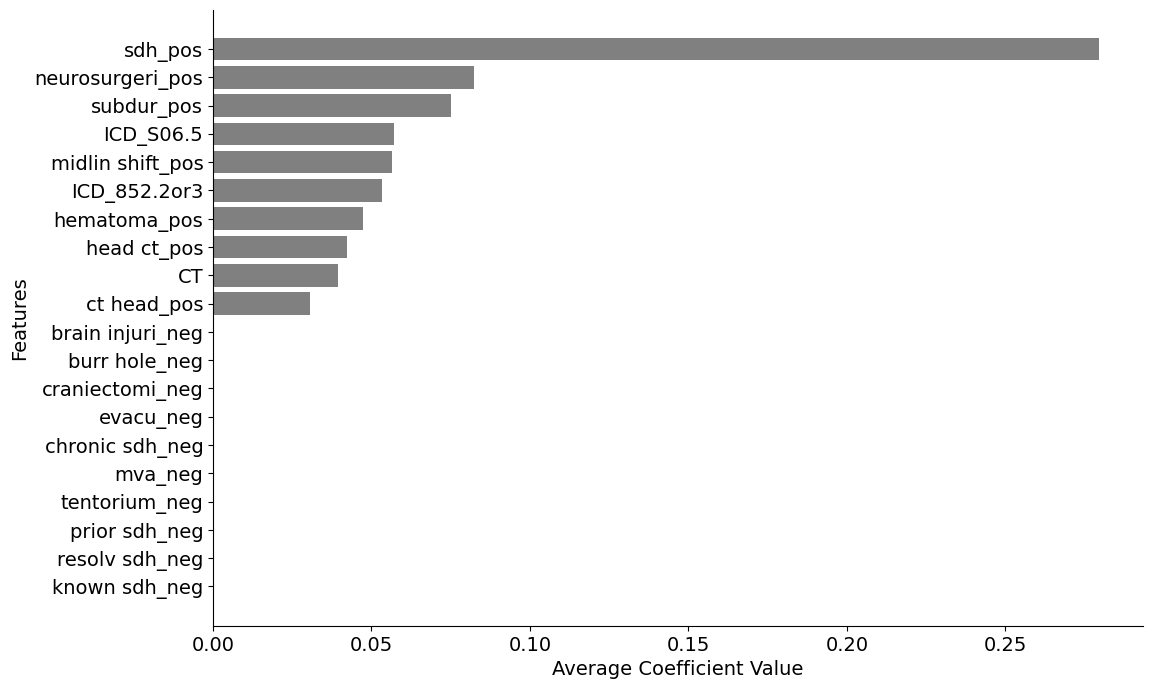

In [12]:
#Calculate and print the feature importances. 
#Convert to a DataFrame.
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

#Save to a CSV.
feature_importances_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_trainBIDMC_testMGB_feat_importances_.csv', index=False)

#Aggregate feature importances by averaging over folds.
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

#Select the top 10 and bottom 10 features. 
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

#Combine the top and bottom features for plotting. 
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

#Plot the feature importances. 
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='grey')  
plt.xlabel('Average Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)  
plt.gca().invert_yaxis()  
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False)  
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_trainBIDMC_testMGB_feat_importances_.png')
plt.show()


In [20]:
#Calculate the confidence intervals. 
def bootstrap_resample(y_true, y_pred_proba, y_pred, n_iterations=1000, alpha=0.95):
    aucs = []
    f1s = []
    precisions = []
    recalls = []
    accuracies = []
    specificities = []
    auc_prs = []
    roc_curves = []
    pr_curves = []
    n_size = len(y_true)
    for _ in range(n_iterations):
        indices = np.random.randint(0, n_size, n_size)
        if len(np.unique(y_true[indices])) < 2:
            continue  
        y_true_resampled = y_true[indices]
        y_pred_proba_resampled = y_pred_proba[indices]
        y_pred_resampled = y_pred[indices]

        #Calculate metrics.
        aucs.append(roc_auc_score(y_true_resampled, y_pred_proba_resampled))
        f1s.append(f1_score(y_true_resampled, y_pred_resampled))
        precisions.append(average_precision_score(y_true_resampled, y_pred_resampled))
        recalls.append(recall_score(y_true_resampled, y_pred_resampled))
        accuracies.append(accuracy_score(y_true_resampled, y_pred_resampled))
        
        #Compute specificity.
        tn, fp, fn, tp = confusion_matrix(y_true_resampled, y_pred_resampled).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
        
        #Compute AUC-PR. 
        precision, recall, _ = precision_recall_curve(y_true_resampled, y_pred_proba_resampled)
        auc_prs.append(auc(recall, precision))
        
        #Compute ROC and PR curves.
        fpr, tpr, _ = roc_curve(y_true_resampled, y_pred_proba_resampled)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))
    
    #Calculate confidence intervals. 
    lower_p = ((1.0 - alpha) / 2.0) * 100
    upper_p = (alpha + ((1.0 - alpha) / 2.0)) * 100
    auc_ci = np.percentile(aucs, [lower_p, upper_p])
    f1_ci = np.percentile(f1s, [lower_p, upper_p])
    precision_ci = np.percentile(precisions, [lower_p, upper_p])
    recall_ci = np.percentile(recalls, [lower_p, upper_p])
    accuracy_ci = np.percentile(accuracies, [lower_p, upper_p])
    specificity_ci = np.percentile(specificities, [lower_p, upper_p])
    auc_pr_ci = np.percentile(auc_prs, [lower_p, upper_p])
    
    return auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves, pr_curves


In [21]:
#Perform bootstrap resampling to get confidence intervals. 
auc_ci, f1_ci, precision_ci, recall_ci, accuracy_ci, specificity_ci, auc_pr_ci, roc_curves_bootstrap, pr_curves_bootstrap = \
    bootstrap_resample(y_test, yte_pred, yte_pred_bin)


In [25]:
#Calculate confidence intervals for ROC. 
roc_fpr_interp = np.linspace(0, 1, 100)
roc_tpr_interp = [np.interp(roc_fpr_interp, fpr, tpr) for fpr, tpr in roc_curves_bootstrap]
roc_mean_tpr = np.mean(roc_tpr_interp, axis=0)
roc_lower_tpr = np.percentile(roc_tpr_interp, 2.5, axis=0)
roc_upper_tpr = np.percentile(roc_tpr_interp, 97.5, axis=0)

#Calculate confidence intervals for PR. 
pr_recall_interp = np.linspace(0, 1, 100)
pr_precision_interp = [np.interp(pr_recall_interp, recall[::-1], precision[::-1]) for precision, recall in pr_curves_bootstrap]
pr_mean_precision = np.mean(pr_precision_interp, axis=0)
pr_lower_precision = np.percentile(pr_precision_interp, 2.5, axis=0)
pr_upper_precision = np.percentile(pr_precision_interp, 97.5, axis=0)





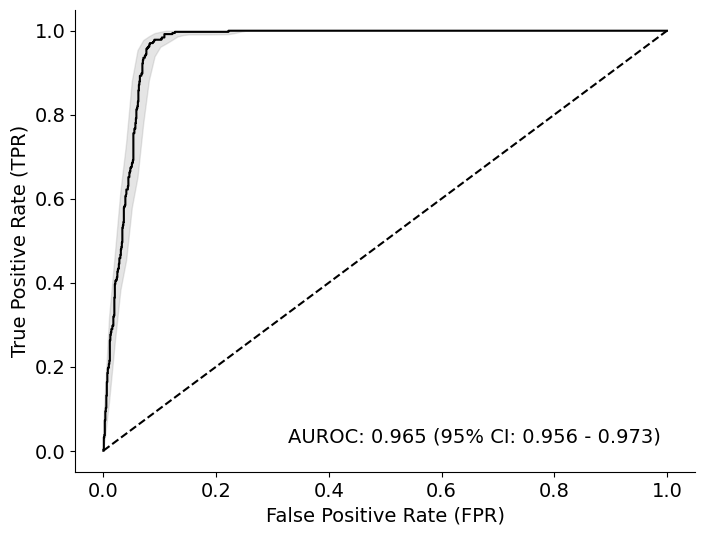

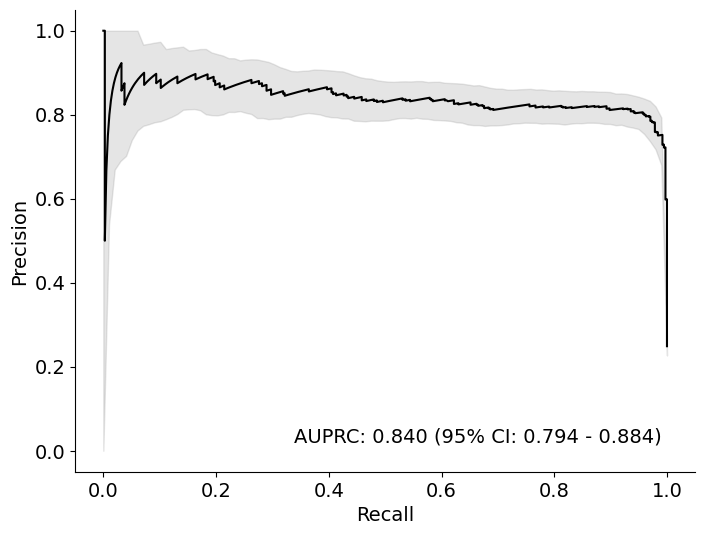

0.964584355163596
[0.8402227515177098]
0.8657465495608532
AUC_Roc: 0.9646 (95% CI: 0.9556 - 0.9726)
AUC_PRC: 0.8402 (95% CI: 0.7945 - 0.8839)


In [30]:
#Create the AUROC and AUPRC graphs. 

#Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))

#Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)
prc_final=np.mean(auc_pr)


for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, color='black')  
    
plt.plot([0, 1], [0, 1], 'k--') 
plt.text(0.99, 0.01, f"AUROC: {auc_final:.3f} (95% CI: {auc_ci[0]:.3f} - {auc_ci[1]:.3f})", ha='right', va='bottom', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.fill_between(roc_fpr_interp, roc_lower_tpr, roc_upper_tpr, color='grey', alpha=0.2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_AUC_iter_MGB_.png')
plt.show()

#Plot all PR curves overlayed on a single graph.
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='black') 
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.fill_between(pr_recall_interp, pr_lower_precision, pr_upper_precision, color='grey', alpha=0.2)
plt.text(0.99, 0.01, f"AUPRC: {prc_final:.3f} (95% CI: {auc_pr_ci[0]:.3f} - {auc_pr_ci[1]:.3f})", ha='right', va='bottom', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_PR_iter_MGB_.png')
plt.show()

#Create a DataFrame to hold the results. 
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

#Save the DataFrame to a CSV file. 
results_df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_LR_iter_pred_MGB_.csv', index=False)

#Save all the data. 
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df_pred = pd.concat([df1]).reset_index()
df.to_csv('/home/gregory178/Desktop/NAX project/NAX_SDH/RF_LR_iter_MGB_.csv')

#Print the final data. 
print(auc_final)
print(auc_pr)
print(f1_final)
print(f"AUC_Roc: {auc_final:.4f} (95% CI: {auc_ci[0]:.4f} - {auc_ci[1]:.4f})")
print(f"AUC_PRC: {prc_final:.4f} (95% CI: {auc_pr_ci[0]:.4f} - {auc_pr_ci[1]:.4f})")
